# Modelo Keras Secuencial


*   5 capas ocultas densas de 500, 1000, 1000, 2000, 2000 unidades
*   Activación LeakyReLU(alpha=0.1)
*   Loss MSE
*   Métrica MAE
*   SGD Learning Rate 1e-2 Momentum 0.0
*   ReduceLrEarlyStoppingBest 1e-6
*   5000 epochs



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LeakyReLU
from keras import backend as K
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split
from datetime import datetime

PATH = r'/content/drive/My Drive/Colab Notebooks/'
PATH_MODELS= r'/content/drive/My Drive/Colab Notebooks/models/'
DATA_INPUT_FILE= r'data_h2o_HF_ccpvdz.csv'
OUTPUT_FILES = r'keras_seq_sgd_16'

# Carga de datos
17636 registros

In [3]:
data= pd.read_csv(PATH + DATA_INPUT_FILE, index_col= 0)
data.describe()

,rh1,rh2,ang,energia
count,17636.000000,17636.000000,17636.000000,17636.000000
mean,1.718462,1.718462,104.482706,-75.741635
std,0.465277,0.465277,4.329904,0.428579
min,0.800000,0.800000,94.500000,-76.027388
25%,1.400000,1.400000,102.500000,-75.992674
50%,1.708000,1.708000,104.500000,-75.924886
75%,2.025000,2.025000,106.500000,-75.722473
max,2.800000,2.800000,114.500000,-72.066162


# Transformación de las variables para el entrenamiento
*   x_input: Se normalizan las variables predictoras
*   y_input: Se le resta el mínimo a la variable objetivo


In [4]:
#Se normalizan las variables predictoras
x = data[['ang', 'rh1', 'rh2']].copy()
x_describe= x.describe()
x_stats = x_describe.transpose()
x_input = (x - x_stats['mean']) / x_stats['std']

# Se le resta el mínimo a la variable objetivo
minimo=min(data['energia'])
y_input = data['energia'].copy() -minimo


# Creación de los conjuntos de train y validación
Conjunto de validación del 10%

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x_input, y_input , random_state = 33, test_size = 0.1)

# Definición de la arquitectura

In [6]:
#Modelo
model = keras.Sequential([
    layers.Dense(500, activation=LeakyReLU(alpha=0.1), input_shape=[len(x_train.keys())]),
    layers.Dense(1000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(1000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(2000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(2000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(1)
  ])

#Optimizador 
optimizer = keras.optimizers.SGD(learning_rate=1e-2)

model.compile( loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mean_squared_logarithmic_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              2002000   
_________________________________________________________________
dense_4 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2001      
Total params: 7,510,001
Trainable params: 7,510,001
Non-trainable params: 0
______________________________________________

# Callback

In [8]:
class ReduceLrEarlyStoppingBest(tf.keras.callbacks.Callback):
  """Detener el entrenamiento cuando la monitorización deja de disminuir.
     Y al acabar el modelo se carga con los pesos del mejor epoch.
     Combina EarlyStopping, ReduceLROnPlateau. 

     Creado a partir del ejemplo EarlyStoppingAtMinLoss de 
     https://www.tensorflow.org/guide/keras/custom_callback?hl=es-419

  Arguments:
      patience: Número de epochs a esperar despues de no haber mejora.
      factor: Número que se multiplicará por lr cuando no mejoré 
              tras cumplirse patience.
      min_lr: Límite inferior de learning rate. Menor valor posible 1e-9!!
      monitor: columna de logs a monitorizar. Menor diferencia detectada 1e-5!!.
  """

  def __init__(self, patience=10, factor=0.1, min_lr = 1e-8, monitor= 'loss'):
    #Inicia class Callback del que toma herencia
    super(ReduceLrEarlyStoppingBest, self).__init__() 

    self.patience = patience
    self.factor= factor
    self.min_lr= min_lr
    self.monitor= monitor

  def on_train_begin(self, logs=None): 
    print('Comienza entrenamiento')
    self.wait = 0 # Número de epoch sin mejora
    self.stopped_epoch = 0 # Epoch de detención anticipada
    self.best = np.inf # mejor valor para monitor
    self.best_epoch = 0 # mejor epoch para monitor
    self.actual_epoch = 0 # epoch actual
    self.best_weights = self.model.get_weights()

  def on_epoch_end(self, epoch, logs=None):
    current = logs.get(self.monitor)
    self.actual_epoch = epoch
    #Si mejora
    if np.less(np.round(current,5), np.round(self.best,5)):
      self.best = current
      self.best_epoch = epoch
      self.wait = 0
      self.best_weights = self.model.get_weights() # Guardar los mejores pesos
      print('Mejor modelo monitor {:g} epoch {:05d}'.format(current, epoch))
    #Si no mejora
    else:
      self.wait += 1
      #Si ha esperado toda la paciencia sin mejorar
      if self.wait >= self.patience:
        lr_actual = tf.keras.backend.get_value(self.model.optimizer.lr)
        #Si ya está en el mínimode lr para
        if not np.greater(np.round(lr_actual,10), np.round(self.min_lr,10)):
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print('Restaurando los pesos del modelo del final de la mejor epoch.')
            self.model.set_weights(self.best_weights)
        #Si no ha llegado al mínimode lr continúa partiendo del mejor
        else:
            self.wait = 0
            lr_futuro = max(lr_actual* self.factor, self.min_lr)
            tf.keras.backend.set_value(self.model.optimizer.lr, lr_futuro)
            print('Nuevo lr {:.2E} en epoch {:05d}.'.format(lr_futuro, epoch+1))
            print('Restaurando pesos del modelo del mejor epoch.')
            self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print('Detencion anticipada!!')
    print('Epoch final %05d' % (self.actual_epoch+1))
    print('{} final: {:g} recuperado del mejor epoch:{:05d}'.format(self.monitor, self.best, self.best_epoch+1))

# Entrenamiento

In [9]:
EPOCHS = 5000

datetime_comienzo = datetime.now()

#Entrenamiento
history = model.fit(
  x_train, y_train, verbose=0, 
  epochs=EPOCHS, validation_data=(x_valid, y_valid)
  ,callbacks=[ReduceLrEarlyStoppingBest(patience=200, factor=0.1, min_lr = 1e-6, monitor= 'val_mae')])

datetime_fin = datetime.now()

#Se guarda el modelo
model.save(PATH_MODELS + OUTPUT_FILES + r'.h5',include_optimizer=True, save_format='h5')

print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )

#Historia de entrenamiento a dataframe
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv(PATH_MODELS + 'hist' + OUTPUT_FILES + r'.csv',index=True)
hist.tail(5) 

Comienza entrenamiento
Mejor modelo monitor 0.111963 epoch 00000
Mejor modelo monitor 0.0624814 epoch 00001
Mejor modelo monitor 0.04494 epoch 00002
Mejor modelo monitor 0.0385158 epoch 00003
Mejor modelo monitor 0.031683 epoch 00004
Mejor modelo monitor 0.0276869 epoch 00005
Mejor modelo monitor 0.0233147 epoch 00006
Mejor modelo monitor 0.0203839 epoch 00007
Mejor modelo monitor 0.0178343 epoch 00008
Mejor modelo monitor 0.0157993 epoch 00009
Mejor modelo monitor 0.0142663 epoch 00010
Mejor modelo monitor 0.013495 epoch 00011
Mejor modelo monitor 0.0119953 epoch 00012
Mejor modelo monitor 0.0112528 epoch 00013
Mejor modelo monitor 0.0106712 epoch 00014
Mejor modelo monitor 0.0100628 epoch 00015
Mejor modelo monitor 0.00962972 epoch 00016
Mejor modelo monitor 0.0090786 epoch 00017
Mejor modelo monitor 0.00865496 epoch 00018
Mejor modelo monitor 0.00849307 epoch 00019
Mejor modelo monitor 0.00758221 epoch 00021
Mejor modelo monitor 0.00738773 epoch 00022
Mejor modelo monitor 0.00685542

,loss,mae,mean_squared_logarithmic_error,val_loss,val_mae,val_mean_squared_logarithmic_error,epoch
2325,0.000334,0.001543,0.000045,0.000011,0.001151,0.000004,2325
2326,0.000334,0.001544,0.000045,0.000011,0.001151,0.000004,2326
2327,0.000334,0.001544,0.000045,0.000011,0.001152,0.000004,2327
2328,0.000334,0.001545,0.000045,0.000011,0.001152,0.000004,2328
2329,0.000334,0.001545,0.000045,0.000011,0.001152,0.000004,2329


# Representación entrenamiento 

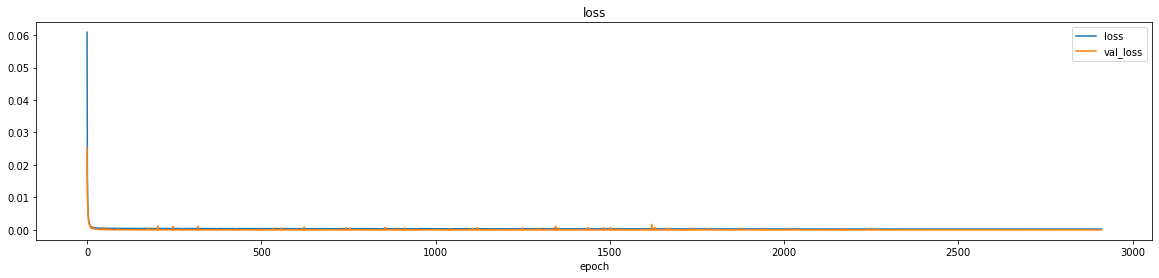

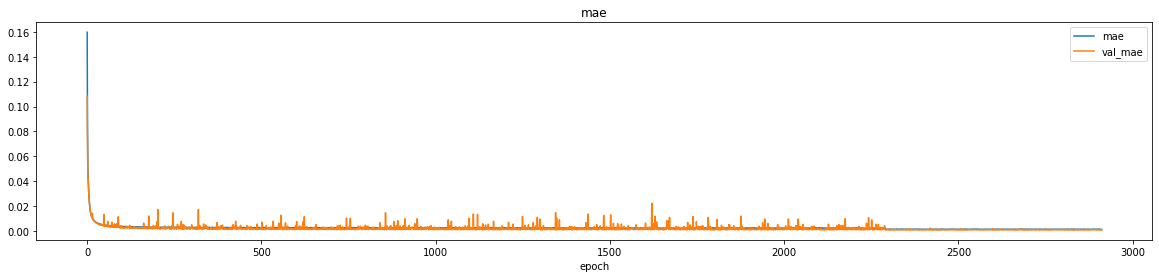

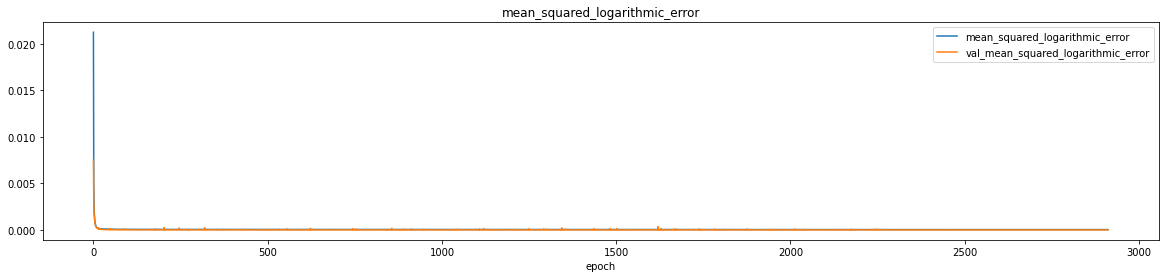

In [ ]:
hist.plot(x='epoch', y=['loss', 'val_loss'], title='loss', figsize=(20,4))
hist.plot(x='epoch', y=['mae', 'val_mae'], title='mae', figsize=(20,4))
hist.plot(x='epoch', y=['mean_squared_logarithmic_error', 'val_mean_squared_logarithmic_error'], title='mean_squared_logarithmic_error', figsize=(20,4))

# Representación entrenamiento 
A partir del epoch 200 para aumentar escala vertical

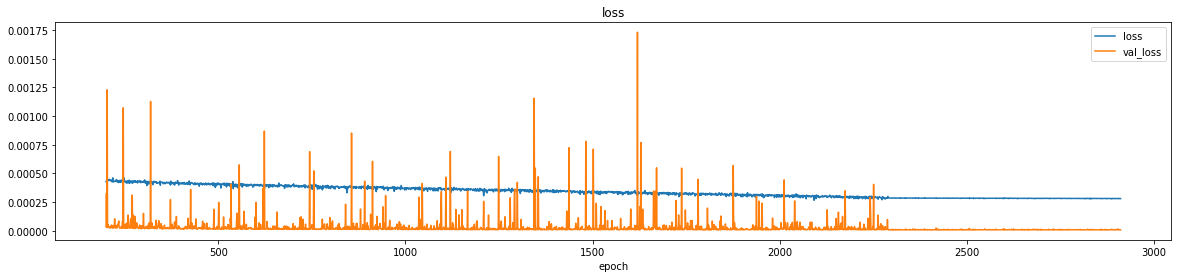

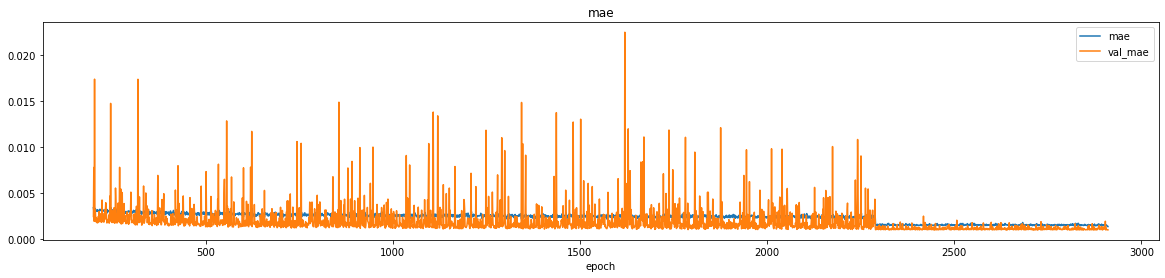

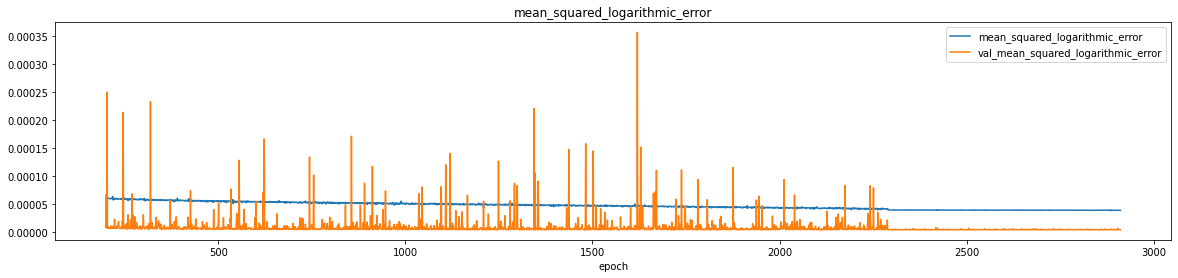

In [ ]:
hist_mayor_200= hist[(hist['epoch']>=200)]
hist_mayor_200.plot(x='epoch', y=['loss', 'val_loss'], title='loss', figsize=(20,4))
hist_mayor_200.plot(x='epoch', y=['mae', 'val_mae'], title='mae', figsize=(20,4))
hist_mayor_200.plot(x='epoch', y=['mean_squared_logarithmic_error', 'val_mean_squared_logarithmic_error'], title='mean_squared_logarithmic_error', figsize=(20,4))

# Mejores épocas

In [ ]:

indice_min_loss =hist['val_loss'].idxmin()
indice_min_mae =hist['val_mae'].idxmin()
indice_min_msle =hist['val_mean_squared_logarithmic_error'].idxmin()

print('Loss (MSE) mínimo: epoch {} valor {:.3E}'.format(hist['epoch'][indice_min_loss],hist['val_loss'][indice_min_loss]))
print('MAE mínimo: epoch {} valor {:.3E}'.format(hist['epoch'][indice_min_mae],hist['val_mae'][indice_min_mae]))
print('MSLE mínimo: epoch {} valor {:.3E}'.format(hist['epoch'][indice_min_msle],hist['val_mean_squared_logarithmic_error'][indice_min_msle]))


Loss (MSE) mínimo: epoch 1835 valor 7.279E-06
MAE mínimo: epoch 2905 valor 1.007E-03
MSLE mínimo: epoch 1835 valor 3.478E-06


# Cargamos el mejor modelo
Y comprobamos que la evaluación corresponde a la mejor época de la métrica de referencia MAE

In [10]:
# Se toma el seq_3cv21_best para no tener que ejecutar todo de nuevo
model_best = keras.models.load_model(PATH_MODELS + OUTPUT_FILES + r'.h5',
                                      custom_objects = {"LeakyReLU": LeakyReLU})
model_best.evaluate(x_valid, y_valid, verbose=2)

56/56 - 0s - loss: 1.0106e-05 - mean_absolute_error: 0.0011 - mean_squared_logarithmic_error: 4.0761e-06


[1.0105954061145894e-05, 0.0011047853622585535, 4.076103323313873e-06]

# Test del modelo con dataset independiente

In [11]:
data_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/output_plotdata_ccpvdz_HF_test.csv")

y_test = data_test.pop("energia")
x_test = data_test

y_test_input = y_test - minimo
x_test_input = (x_test - x_stats['mean']) / x_stats['std']

model_best.evaluate(x_test_input, y_test_input, verbose=2)

50/50 - 0s - loss: 4.7435e-04 - mean_absolute_error: 0.0016 - mean_squared_logarithmic_error: 2.3331e-04


[0.00047434907173737884, 0.0015864736633375287, 0.0002333129959879443]

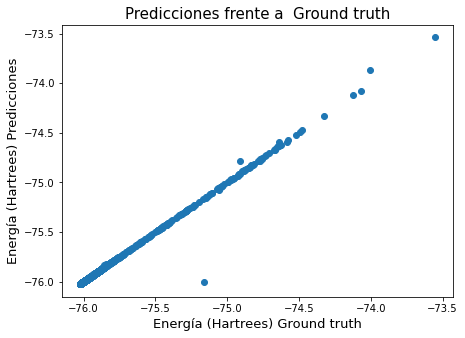

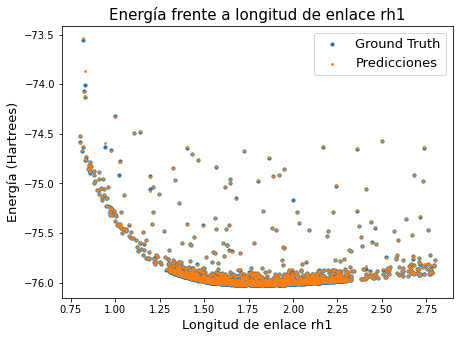

In [12]:
test_predictions = model_best.predict(x_test_input).flatten() 

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(y_test, test_predictions + minimo)
ax.set_title('Predicciones frente a  Ground truth', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x_test['rh1'], y_test, label='Ground Truth', s=10)
ax.scatter(x_test['rh1'], test_predictions + minimo, label='Predicciones', s=3)
ax.set_title('Energía frente a longitud de enlace rh1', fontsize=15)
ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()

# Energía frente a una distancia de enlace
Fijando la otra distancia de enlace a 1.808 ua y el ángulo a 104.5 grados

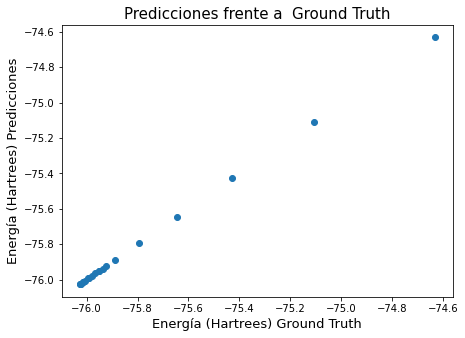

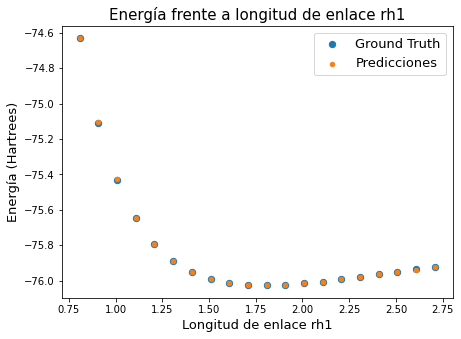

In [13]:
x_long_enlace = data[(np.round(data["ang"],1)==104.5) & (np.round(data["rh2"],3)==1.808)].copy()
y_long_enlace =x_long_enlace.pop("energia")
x_long_enlace_input = (x_long_enlace - x_stats['mean']) / x_stats['std']

test_predictions_long_enlace = model_best.predict(x_long_enlace_input).flatten()
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(y_long_enlace, test_predictions_long_enlace + minimo)
ax.set_title('Predicciones frente a  Ground Truth', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground Truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)


fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x_long_enlace['rh1'], y_long_enlace, label='Ground Truth', s=40)
ax.scatter(x_long_enlace['rh1'], test_predictions_long_enlace + minimo, label='Predicciones', s=20)
ax.set_title('Energía frente a longitud de enlace rh1', fontsize=15)
ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()




plt.show()

# Energía frente al ángulo
Fijando las dos distancias de enelace a 1.808

Ángulo en el vértice de la parábola: 101.61


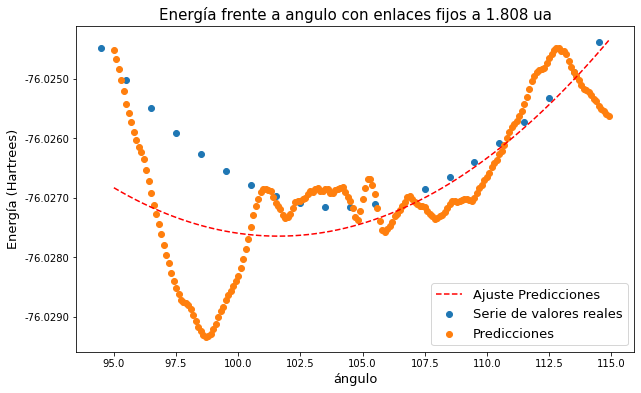

In [14]:
x_data_ang = data[(np.round(data['rh1'],3)==1.808) & (np.round(data['rh2'],3)==1.808)].copy()
y_data_ang =x_data_ang.pop("energia")

x_arange = pd.DataFrame()
x_arange['ang']= np.arange(95, 115, 0.1)
x_arange['rh1'] =1.808
x_arange['rh2'] =1.808
x_arange_input = (x_arange - x_stats['mean']) / x_stats['std']
test_predictions_arrange_ang = model_best.predict(x_arange_input).flatten()

z = np.polyfit(x_arange['ang'], test_predictions_arrange_ang + minimo, 2)
p = np.poly1d(z)
ang_vertice = -p.coefficients[1]/(2*p.coefficients[0])
print('Ángulo en el vértice de la parábola: {:.2f}'.format(ang_vertice))


fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x_data_ang['ang'], y_data_ang , label='Serie de valores reales')
ax.scatter(x_arange['ang'], test_predictions_arrange_ang + minimo, label='Predicciones')
ax.plot(x_arange['ang'],p(x_arange['ang']),"r--", label= 'Ajuste Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.808 ua', fontsize=15)
ax.set_xlabel('ángulo', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend(fontsize=13)

plt.show()



Fijando las dos distancias de enelace a 1.708



Ángulo en el vértice de la parábola: 106.72


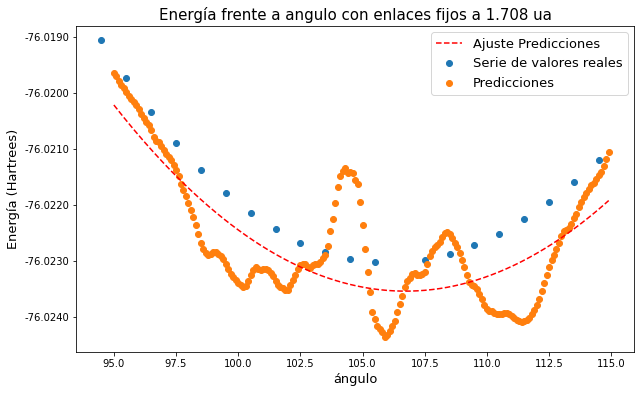

In [15]:
x_data_ang = data[(np.round(data['rh1'],3)==1.708) & (np.round(data['rh2'],3)==1.708)].copy()
y_data_ang =x_data_ang.pop("energia")

x_arange = pd.DataFrame()
x_arange['ang']= np.arange(95, 115, 0.1)
x_arange['rh1'] =1.708
x_arange['rh2'] =1.708
x_arange_input = (x_arange - x_stats['mean']) / x_stats['std']
test_predictions_arrange_ang = model_best.predict(x_arange_input).flatten()

z = np.polyfit(x_arange['ang'], test_predictions_arrange_ang + minimo, 2)
p = np.poly1d(z)
ang_vertice = -p.coefficients[1]/(2*p.coefficients[0])
print('Ángulo en el vértice de la parábola: {:.2f}'.format(ang_vertice))


fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x_data_ang['ang'], y_data_ang , label='Serie de valores reales')
ax.scatter(x_arange['ang'], test_predictions_arrange_ang + minimo, label='Predicciones')
ax.plot(x_arange['ang'],p(x_arange['ang']),"r--", label= 'Ajuste Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.708 ua', fontsize=15)
ax.set_xlabel('ángulo', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend(fontsize=13)

plt.show()